In [1]:
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from shapeworld_data import load_raw_data, get_vocab, ShapeWorld

c:\Users\mange\miniconda3\envs\rsa\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly iden

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
def check_raw_data(imgs, labels, langs, id=0):
    data = list(zip(imgs,labels,langs))
    img_list,label,lang = data[id]
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6, 2))
    fig.suptitle(" ".join(lang))
    for i,(l,img) in enumerate(zip(label,img_list)):
        img = img.transpose((2,1,0))
        axes[i].imshow(img)
        if l==1: axes[i].set_title("Correct")
    plt.show()

## Main test code

### prepare data

In [4]:
root = Path(os.path.abspath('')).parent.parent.absolute()
data_path = os.path.join(root,"data\shapeworld_np")
print(data_path)
data_list = os.listdir(data_path)
print(data_list)

c:\Users\mange\Desktop\Neural-RSA_with_pre-trained-LM\pre-trained_RSA\data\shapeworld_np
['reference-1000-0.npz', 'reference-1000-1.npz', 'reference-1000-2.npz', 'reference-1000-3.npz', 'reference-1000-4.npz']


In [5]:
vocab = get_vocab([os.path.join(data_path,d) for d in data_list])
print(vocab["w2i"])

c:\Users\mange\Desktop\Neural-RSA_with_pre-trained-LM\pre-trained_RSA\code\ShapeWorld_relative_literal_listener\shapeworld_data.py:201: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  'langs': np.array([t.lower().split() for t in data['langs']])


{'<PAD>': 0, '<sos>': 1, '<eos>': 2, '<UNK>': 3, 'blue': 4, 'shape': 5, 'circle': 6, 'ellipse': 7, 'gray': 8, 'white': 9, 'red': 10, 'rectangle': 11, 'square': 12, 'yellow': 13, 'green': 14}


(1000, 3, 3, 64, 64)
(1000, 3)
(1000,)


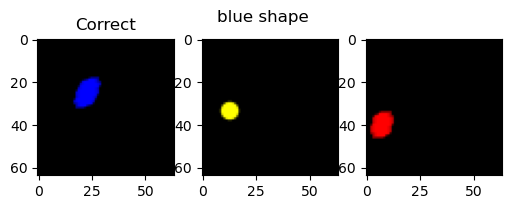

In [6]:
d = load_raw_data(os.path.join(data_path,data_list[0]))
print(d["imgs"].shape)
print(d["labels"].shape)
print(d["langs"].shape)
check_raw_data(d["imgs"],d["labels"],d["langs"])
train_batch = DataLoader(ShapeWorld(d, vocab), batch_size=32, shuffle=False)

(1000, 3, 3, 64, 64)
(1000, 3)
(1000,)


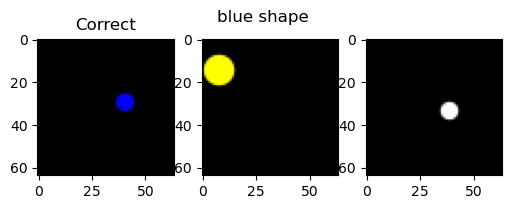

In [7]:
d = load_raw_data(os.path.join(data_path,data_list[-1]))
print(d["imgs"].shape)
print(d["labels"].shape)
print(d["langs"].shape)
check_raw_data(d["imgs"],d["labels"],d["langs"])
test_batch = DataLoader(ShapeWorld(d, vocab), batch_size=32, shuffle=False)

### Model setting

In [8]:
from cs_cnn import CNN_encoder

class ShapeWorld_RNN_L0(nn.Module):
    def __init__(self,vocab_size,emb_dim=768,hidden_dim=1024) -> None:
        super(ShapeWorld_RNN_L0,self).__init__()
        self.embedding_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.cnn_color_encoder = CNN_encoder(6)
        self.cnn_color_encoder.load_state_dict(torch.load("model_params/shapeworld_original-cnn_color_model.pth",map_location=device))
        self.cnn_shape_encoder = CNN_encoder(4)
        self.cnn_shape_encoder.load_state_dict(torch.load("model_params/shapeworld_original-cnn_shape_model.pth",map_location=device))
        self.to_hidden = nn.Linear(10,self.hidden_dim)
        self.rnn = nn.GRU(emb_dim, hidden_dim, dropout=0.5, batch_first=True, bidirectional=True)
        
    def embed_features(self, imgs):
        imgs01 = imgs[:,0]
        imgs02 = imgs[:,1]
        imgs03 = imgs[:,2]
        feats_emb_flats = []
        for imgs in [imgs01,imgs02,imgs03]:
            color_embs = self.cnn_color_encoder(imgs)
            shape_embs = self.cnn_shape_encoder(imgs)
            feats_emb = torch.hstack((color_embs, shape_embs))
            feats_emb_flats.append(feats_emb)
        cnn_emb = torch.stack(tuple(feats_emb_flats),dim=1)
        feat_embs = self.to_hidden(cnn_emb)
        return feat_embs

    def forward(self,imgs,contexts):
        embs = self.embedding(contexts)
        _, hidden = self.rnn(embs)
        lang_embs = hidden[-1].view(-1,self.hidden_dim)
        imgs_emb = self.embed_features(imgs)
        #print(imgs_emb.shape,lang_embs.shape)
        scores = F.softmax(torch.einsum('ijh,ih->ij', (imgs_emb, lang_embs)),dim=-1)
        return scores


In [9]:
model = ShapeWorld_RNN_L0(len(vocab["w2i"].keys()))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
epoch = 30

c:\Users\mange\miniconda3\envs\rsa\lib\site-packages\torch\nn\modules\rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


### Training

In [12]:
def get_relative_accuracy(model,test_batch):
    correct_num = 0
    total_num = 0
    for imgs,labels,langs in test_batch:
        imgs,labels,langs = imgs.to(torch.float).to(device),labels.to(torch.float).to(device),langs.to(device)
        y_pred_prob = model(imgs,langs)
        y_pred = torch.max(y_pred_prob,1)[1]
        labels = torch.max(labels,1)[1]
        correct_num += torch.sum(y_pred==labels).item()
        total_num += len(labels)
    return correct_num/total_num

In [13]:
def train_model(model,train_batch,criterion,optimizer,do_break=False):
    train_loss = 0
    model.train()
    for imgs,labels,langs in train_batch:
        imgs,labels,langs = imgs.to(torch.float).to(device),labels.to(torch.float).to(device),langs.to(device)
        optimizer.zero_grad()
        y_pred = model(imgs,langs)
        loss = criterion(y_pred,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if do_break: break
    batch_train_loss = train_loss/len(train_batch)
    batch_train_acc = get_relative_accuracy(model, train_batch)
    return batch_train_loss, batch_train_acc

def eval_model(model,test_batch,criterion,do_break=False):
    test_loss = 0
    model.eval()
    with torch.no_grad():
        for imgs,labels,langs in test_batch:
            imgs,labels,langs = imgs.to(torch.float).to(device),labels.to(torch.float).to(device),langs.to(device)
            y_pred = model(imgs,langs)
            loss = criterion(y_pred,labels)
            test_loss += loss.item()
            if do_break: break
    batch_test_loss = test_loss/len(test_batch)
    batch_test_acc = get_relative_accuracy(model,test_batch)
    return batch_test_loss, batch_test_acc


def train_and_eval_epochs(model,criterion,optimizer,epoch,train_batch,test_batch,log=True,do_break=False):
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    best_loss = 100
    best_acc = 0
    for i in range(epoch):
        if log:
            print("##############################################")
            print("Epoch:{}/{}".format(i+1,epoch))
        batch_train_loss, batch_train_acc = train_model(model,train_batch,criterion,optimizer,do_break=do_break)
        batch_test_loss, batch_test_acc = eval_model(model,test_batch,criterion,do_break=do_break)
        if log:
            print("Train Loss:{:.2E}, Test Loss:{:.2E}".format(batch_train_loss,batch_test_loss))
            print("Train Acc:{:.2E}, Test Acc:{:.2E}".format(batch_train_acc,batch_test_acc))
        train_loss_list.append(batch_train_loss)
        test_loss_list.append(batch_test_loss)
        train_acc_list.append(batch_train_acc)
        test_acc_list.append(batch_test_acc)
        if batch_test_loss < best_loss:
            if log: print("Best Loss saved ...")
            torch.save(model.to(device).state_dict(),"model_params/emb-rnn-l0_best-loss.pth")
            best_loss = batch_test_loss
        if batch_test_acc > best_acc:
            if log: print("Best Acc saved ...")
            torch.save(model.to(device).state_dict(),"model_params/emb-rnn-l0_best-acc.pth")
            best_acc = batch_test_acc
        if do_break: break
    return train_loss_list,test_loss_list,train_acc_list,test_acc_list

In [21]:
# train and eval with epoch
tr_loss,ts_loss,tr_acc,ts_acc = train_and_eval_epochs(model,criterion,optimizer,epoch,train_batch,test_batch,log=True,do_break=False)
metrics = np.array([tr_loss,ts_loss,tr_acc,ts_acc])
np.save("metrics/emb-rnn-l0.npy",metrics)

##############################################
Epoch:1/30
Train Loss:9.63E-01, Test Loss:9.56E-01
Train Acc:6.22E-01, Test Acc:6.10E-01
Best Loss saved ...
Best Acc saved ...
##############################################
Epoch:2/30
Train Loss:9.40E-01, Test Loss:9.51E-01
Train Acc:6.80E-01, Test Acc:6.51E-01
Best Loss saved ...
Best Acc saved ...
##############################################
Epoch:3/30
Train Loss:8.98E-01, Test Loss:8.92E-01
Train Acc:6.91E-01, Test Acc:6.70E-01
Best Loss saved ...
Best Acc saved ...
##############################################
Epoch:4/30
Train Loss:8.54E-01, Test Loss:8.25E-01
Train Acc:7.10E-01, Test Acc:7.34E-01
Best Loss saved ...
Best Acc saved ...
##############################################
Epoch:5/30
Train Loss:8.52E-01, Test Loss:9.02E-01
Train Acc:6.79E-01, Test Acc:6.65E-01
##############################################
Epoch:6/30
Train Loss:8.89E-01, Test Loss:9.54E-01
Train Acc:6.57E-01, Test Acc:6.34E-01
############################

In [4]:
import numpy as np
metric = np.load("metrics/emb-rnn-l0.npy")
test_acc_list = metric[-1]
epoch = 30
for i in range(epoch):
    acc = test_acc_list[i]
    if acc>0.65: 
        print("Exceeding 0.65 at epoch ",i+1)
        break

Exceeding 0.65 at epoch  2


### Accuracy Test

In [10]:
model = ShapeWorld_RNN_L0(len(vocab["w2i"].keys()))
model.to(device)
model.load_state_dict(torch.load("model_params/emb-rnn-l0_best-loss.pth",map_location=device))

<All keys matched successfully>

In [26]:
def get_prob_labels(lang_probs):
    lang_pred = []
    for probs in lang_probs:
        if probs[0]==probs[1] and probs[1]==probs[2]: # all same
            lang_pred.append(int(np.random.randint(3)))
        elif probs[0]==probs[1] and max(probs)==probs[0]:
            lang_pred.append(int(0 if np.random.randint(2)==0 else 1))
        elif probs[1]==probs[2] and max(probs)==probs[1]:
            lang_pred.append(int(1 if np.random.randint(2)==0 else 2))
        elif probs[0]==probs[2] and max(probs)==probs[1]:
            lang_pred.append(int(0 if np.random.randint(2)==0 else 2))
        else:
            lang_pred.append(int(torch.argmax(probs)))
    return np.array(lang_pred)

In [11]:
correct_num = 0
total_num = 0
for imgs,labels,langs in test_batch:
    imgs,labels,langs = imgs.to(torch.float).to(device),labels.to(torch.float).to(device),langs.to(device)
    #print(torch.sum(label))
    y_pred_prob = model(imgs,langs)
    y_pred = torch.max(y_pred_prob,1)[1]
    labels = torch.max(labels,1)[1]
    correct_num += sum(y_pred==labels).item()
    total_num += len(labels)
    
print("Total number of data for this evaluatio is ",total_num)
print("Classification accuracy is ",correct_num/total_num)

Total number of data for this evaluatio is  1000
Classification accuracy is  0.703
